In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os


In [2]:
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""
db = "../cluster-experiments/cv_results/params.db"
with sqlite3.connect(os.path.realpath(db)) as con:
    cur = con.cursor()
    cur.execute(sql_query)
    print(cur.fetchall())

[('studies',), ('version_info',), ('study_directions',), ('study_user_attributes',), ('study_system_attributes',), ('trials',), ('trial_user_attributes',), ('trial_system_attributes',), ('trial_params',), ('trial_values',), ('trial_intermediate_values',), ('trial_heartbeats',), ('alembic_version',)]


In [3]:
sql_query = """SELECT * FROM trial_values;"""
with sqlite3.connect(db) as con:
    cur = con.cursor()
    cur.execute(sql_query)
    names = list(map(lambda x: x[0], cur.description))
    res = [dict(zip(names, x)) for x in cur.fetchall()] 
pd.DataFrame.from_dict(res)

,trial_value_id,trial_id,objective,value,value_type
0,151,151,0,0.014686,FINITE
1,152,152,0,0.090458,FINITE
2,153,153,0,0.000000,FINITE
3,154,154,0,0.000000,FINITE
4,155,155,0,0.085830,FINITE
...,...,...,...,...,...
5247,9077,9189,0,0.821047,FINITE
5248,9078,9190,0,0.813649,FINITE
5249,9079,9191,0,0.794051,FINITE
5250,9080,9192,0,0.369237,FINITE


In [4]:
sql_query = """SELECT * FROM studies;"""
with sqlite3.connect(db) as con:
    cur = con.cursor()
    cur.execute(sql_query)
    names = list(map(lambda x: x[0], cur.description))
    res = [dict(zip(names, x)) for x in cur.fetchall()] 
pd.DataFrame.from_dict(res)

,study_id,study_name
0,4,bert-tiny__4 -__0
1,9,bert-tiny__INCLUDE
2,10,bert-tiny__4 -
3,47,scincl__INCLUDE
4,48,climatebert__INCLUDE
...,...,...
102,188,distilroberta-base__8 -__2
103,189,distilroberta-base__8 -__1
104,190,distilroberta-base__10 -__0
105,191,distilroberta-base__10 -__1


In [5]:
sql_query = """SELECT * FROM trials;"""
with sqlite3.connect(db) as con:
    cur = con.cursor()
    cur.execute(sql_query)
    names = list(map(lambda x: x[0], cur.description))
    res = [dict(zip(names, x)) for x in cur.fetchall()] 
pd.DataFrame.from_dict(res)

,trial_id,number,study_id,state,datetime_start,datetime_complete
0,151,0,4,COMPLETE,2023-03-22 13:35:28.346967,2023-03-22 13:35:34.619096
1,152,1,4,COMPLETE,2023-03-22 13:35:34.705378,2023-03-22 13:35:38.871199
2,153,2,4,COMPLETE,2023-03-22 13:35:38.957166,2023-03-22 13:35:45.018501
3,154,3,4,COMPLETE,2023-03-22 13:35:45.106109,2023-03-22 13:35:54.392537
4,155,4,4,COMPLETE,2023-03-22 13:35:54.477963,2023-03-22 13:36:02.019304
...,...,...,...,...,...,...
5247,9189,45,191,COMPLETE,2023-06-30 06:00:36.358748,2023-06-30 06:02:04.491013
5248,9190,46,191,COMPLETE,2023-06-30 06:02:04.686932,2023-06-30 06:04:22.909004
5249,9191,47,191,COMPLETE,2023-06-30 06:04:23.101250,2023-06-30 06:06:23.989840
5250,9192,48,191,COMPLETE,2023-06-30 06:06:24.207196,2023-06-30 06:08:09.384281


In [6]:
def return_search(study_name):
    sql_query = f"""
    SELECT s.study_id, s.study_name, t.trial_id, t.number, tv.value, tp.param_name, tp.param_value
    FROM trials t
    INNER JOIN 
        studies s 
    ON t.study_id = s.study_id
        AND s.study_name LIKE "%{study_name}__%"
    INNER JOIN 
        trial_values tv
    ON t.trial_id = tv.trial_id
    INNER JOIN 
        trial_params as tp
    ON
        t.trial_id = tp.trial_id;
    """
    with sqlite3.connect(db) as con:
        cur = con.cursor()
        cur.execute(sql_query)
        names = list(map(lambda x: x[0], cur.description))
        res = [dict(zip(names, x)) for x in cur.fetchall()] 
    df = pd.DataFrame.from_dict(res)
    return df




scincl__19 -__0
scincl__19 -__1
scincl__19 -__2


,study_id,study_name,trial_id,number,value,param_name,param_value
0,104,scincl__19 -__0,4790,0,0.759934,learning_rate,0.000125
1,104,scincl__19 -__0,4790,0,0.759934,num_train_epochs,3.000000
2,104,scincl__19 -__0,4790,0,0.759934,per_device_train_batch_size,1.000000
3,104,scincl__19 -__0,4790,0,0.759934,use_class_weights,0.000000
4,104,scincl__19 -__0,4790,0,0.759934,weight_decay,0.157159


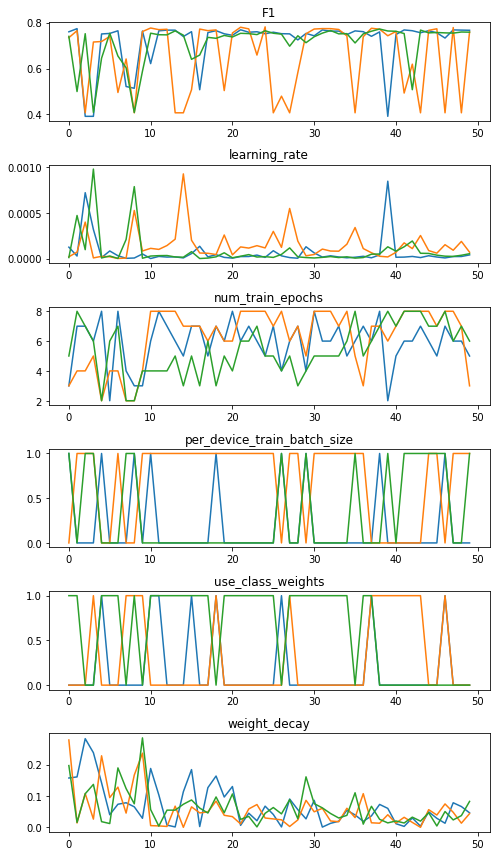

In [8]:
model_name = "scincl"
y_prefix = "19 -"
study_name = f"{model_name}__{y_prefix}"
df = return_search(study_name)

fig, axs = plt.subplots(6, figsize=(7,12))
for fold, group in df.groupby("study_name"):
    print(fold)
    vals = group.groupby("number")["value"].mean()
    axs[0].plot(vals)
    for i, (p, pgroup) in enumerate(group.groupby("param_name")):
        pgroup = pgroup.sort_values("number").reset_index(drop=True)
        axs[i+1].plot(pgroup["param_value"])
        axs[i+1].set_title(p)
        
axs[0].set_title("F1")
        
fig.tight_layout()
df.head()

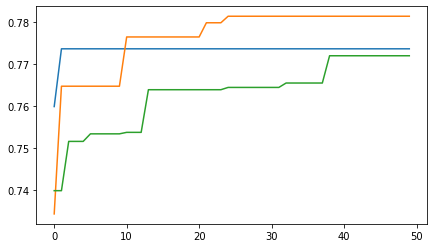

In [13]:
fig, ax = plt.subplots(figsize=(7,4))
for fold, group in df.groupby("study_name"):
    f1_max = group.groupby('number')['value'].max().cummax()
    ax.plot(f1_max)
    

scincl__4 -__0
scincl__4 -__1
scincl__4 -__2


,study_id,study_name,trial_id,number,value,param_name,param_value
0,135,scincl__4 -__1,6196,0,0.165669,learning_rate,0.000001
1,135,scincl__4 -__1,6196,0,0.165669,num_train_epochs,2.000000
2,135,scincl__4 -__1,6196,0,0.165669,per_device_train_batch_size,1.000000
3,135,scincl__4 -__1,6196,0,0.165669,use_class_weights,0.000000
4,135,scincl__4 -__1,6196,0,0.165669,weight_decay,0.228721


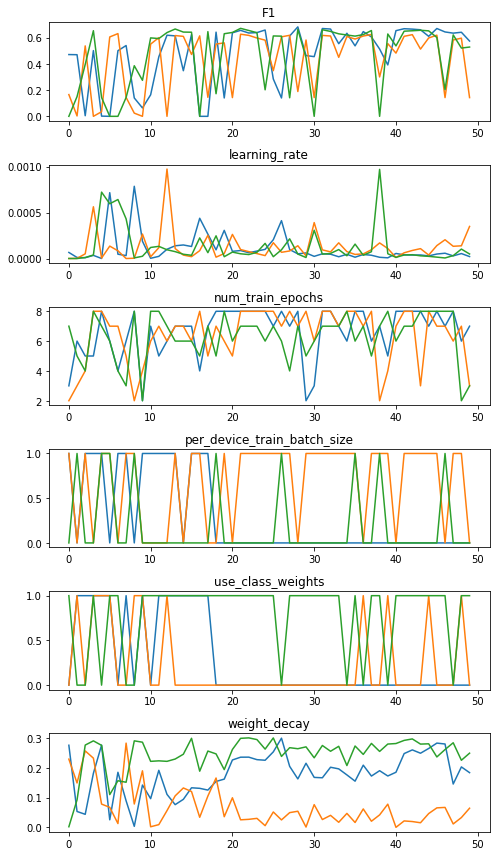

In [8]:
model_name = "scincl"
y_prefix = "4 -"
study_name = f"{model_name}__{y_prefix}"
df = return_search(study_name)

fig, axs = plt.subplots(6, figsize=(7,12))
for fold, group in df.groupby("study_name"):
    print(fold)
    vals = group.groupby("number")["value"].mean()
    axs[0].plot(vals)
    for i, (p, pgroup) in enumerate(group.groupby("param_name")):
        pgroup = pgroup.sort_values("number").reset_index(drop=True)
        axs[i+1].plot(pgroup["param_value"])
        axs[i+1].set_title(p)
        
axs[0].set_title("F1")
        
fig.tight_layout()
df.head()

scincl__INCLUDE__0
scincl__INCLUDE__1
scincl__INCLUDE__2


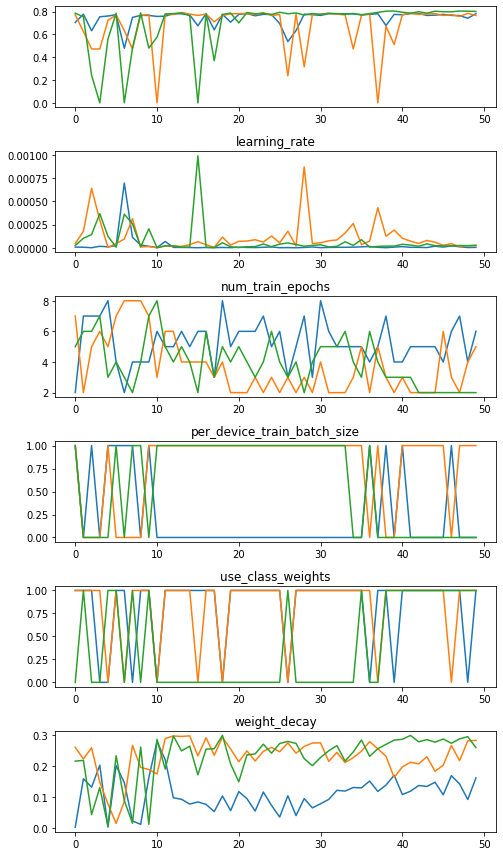

In [9]:
model_name = "scincl"
y_prefix = "INCLUDE"
study_name = f"{model_name}__{y_prefix}"
df = return_search(study_name)

fig, axs = plt.subplots(6, figsize=(7,12))
axs[0]
for fold, group in df.groupby("study_name"):
    print(fold)
    vals = group.groupby("number")["value"].mean()
    axs[0].plot(vals)
    for i, (p, pgroup) in enumerate(group.groupby("param_name")):
        pgroup = pgroup.sort_values("number").reset_index(drop=True)
        axs[i+1].plot(pgroup["param_value"])
        axs[i+1].set_title(p)
        
fig.tight_layout()

In [10]:
labels = pd.read_feather("../data/0_labelled_documents.feather")
labels.head()

,id,title,content,0 - relevant,10 - 3. Quantitative,10 - 4. Qualitative,2 - 0. Mitigation,2 - 1. Adaptation,3 - 0. Not policy related,3 - 1. Analysis of an existing policy / concrete proposal,...,5 - 4.17. Government administration & management,representative_sample,representative_relevant,17 - 0. Supranational and international,17 - 1. National,17 - 2. Sub-national,19 - 0. Ex-post,19 - 1. Ex-ante,PY,wosarticle__di
0,156,THE EXPECTED GREENHOUSE BENEFITS FROM DEVELOPI...,Magma power is the production of electricity f...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0.0,1995.0,10.1002/er.4440190104
1,337,Energy forecast till 2020 for the German Gover...,A study conducted by the Prognos economic rese...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0.0,1996.0,None
2,921,Ontology engineering in provenance enablement ...,The National Climate Assessment of the U.S. Gl...,1.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0,0,1,0.0,0.0,0.0,0.0,0.0,2014.0,10.1016/j.envsoft.2014.08.002
3,1448,"Planning, governance and rural futures in Aust...",Rural regions in post-industrial countries con...,1.0,NaN,NaN,0.0,1.0,0.0,0.0,...,0,0,1,NaN,NaN,NaN,NaN,NaN,2015.0,10.1080/09640568.2014.940514
4,3556,Will economic restructuring in China reduce tr...,We calculate carbon dioxide (CO2) emissions em...,1.0,1.0,1.0,1.0,0.0,0.0,2.0,...,0,0,1,0.0,1.0,0.0,1.0,0.0,2014.0,10.1016/j.eneco.2013.12.011


In [11]:
cdict = {
    "2 -": "Response",
}
import json

models = ["climatebert","distilroberta-base"]
models = ["bert-tiny", "distilroberta-base"]
models = ["bert-tiny","climatebert", "distilroberta-base","scincl"]
models = ["scincl", "climatebert","distilroberta-base"]
models = ["climatebert"]
ys = ["0 -", "3 -"]
ys = ["0 -"]
ys = ["0 -","2 -","3 -","4 -","5 -","6 -"]
ys = cdict.keys()
#ys = ["2 -", "3 -", "4 -"]
scores = []
for model_name in models:
    for y in ys:
        for k in range(3):
            study_name = f"{model_name}__{y}__{k}"
            print(study_name)
            try:
                with open(f"../cluster-experiments/cv_results/{study_name}.json", "r") as f:
                    res = json.load(f)
                    try:
                        res = {**res["hyperparameters"],**res["scores"],**res["evaluated_scores"]}
                    except:
                        print("Could not load evaluated_scores")
                        continue
                    res["model"] = model_name
                    res["y"] = y
                    res["k"] = k
                    scores.append(res)
            except FileNotFoundError:
                print("Could not find file")
                
score_df = pd.DataFrame.from_dict(scores)
if "F1" not in score_df.columns:
    score_df['F1'] = score_df['F1 macro']
naf1 = pd.isna(score_df["F1"])
score_df.loc[naf1,"F1"] = score_df.loc[naf1,"F1 macro"]
def mean_std(x):
    m = np.mean(x)
    sd = np.std(x)
    return f"{m:.2} ({sd:.2})"
score_tab = score_df.pivot_table(index="y",columns="model",values="F1", aggfunc=mean_std).reset_index()



score_tab.columns.name = None
score_tab["y"] = score_tab["y"].apply(lambda x: cdict[x])
score_tab = score_tab.rename(columns={"y":"Category"}).fillna("").sort_values("Category", ascending=True)
score_tab.loc[score_tab.shape[0],:] = ["Total"] + list(score_df.groupby("model")["F1"].aggregate(mean_std).values)
vis = score_tab.style.highlight_max(
    subset=models,
    props='font-weight:bold;',
    #props='color:red',
    axis=1
).hide()
out = score_tab.style.highlight_max(
    subset=models,
    props='textbf:--rwrap',
    #props='color:red',
    axis=1,
).hide()
# out.to_latex(
#     "../tables/predictions.tex",
#     hrules=True
# )
vis

climatebert__2 -__0
climatebert__2 -__1
climatebert__2 -__2


Category,climatebert
Response,0.8 (0.098)
Total,0.8 (0.098)


In [12]:
def find_n(c):
    c = [x for x in labels.columns if c in x or c.replace("and","&") in x][0]
    return labels[labels[c]>0.5].shape[0]

def sub_results(y, fpath=None):
    sub_df = score_df[score_df["y"]==y]
    cols = [x for x in score_df.columns if re.match(f"F1 - {y}",x)]
    sub_df = sub_df.melt(id_vars=["k","model"], value_vars=cols)
    print(sub_df.variable.unique())
    sub_df["variable"] = sub_df["variable"].apply(lambda x: x.split(".")[-1].replace("&","and"))
    piv = sub_df.pivot_table(index="variable",columns="model",values="value", aggfunc=mean_std).reset_index()
    piv["n"] = piv["variable"].apply(find_n)
    piv["variable"] = piv["variable"].apply(lambda x: " ".join(x.split()[:6]))
    piv.columns.name = None
    if fpath:
        piv.rename(columns={"variable":"Sub-category"}).style.highlight_max(
            props='textbf:--rwrap',
            subset=models,
            axis=1
        ).hide().to_latex(fpath, hrules=True)
    piv = piv.rename(columns={"variable":"Sub-category"}).style.highlight_max(
        props='font-weight:bold;',
        subset=models,
        axis=1
    ).hide()

    return piv

tab = sub_results("2 -")
tab

['F1 - 2 - 0. Mitigation' 'F1 - 2 - 1. Adaptation']


Sub-category,climatebert,n
Adaptation,0.6 (0.2),238
Mitigation,1.0 (0.0),1810


In [13]:
cdict = {
    "INCLUDE": "1. Relevance",
    "4 -": "2. Instrument I",
    "5 -": "3. Instrument II",
    "6 -": "4. Instrument III",
    "10 -": "8. Qualitative/Quantitative",
    "17 -": "6. Governance level",
    "8 -": "5. Sector",
    "19 -": "7. Ex-post/ex-ante"
}

In [14]:
import json

models = ["climatebert","distilroberta-base"]
models = ["bert-tiny", "distilroberta-base"]
models = ["bert-tiny","climatebert", "distilroberta-base","scincl"]
models = ["scincl", "climatebert","distilroberta-base"]
ys = ["0 -", "3 -"]
ys = ["0 -"]
ys = ["0 -","2 -","3 -","4 -","5 -","6 -"]
ys = cdict.keys()
#ys = ["2 -", "3 -", "4 -"]
scores = []
for model_name in models:
    for y in ys:
        for k in range(3):
            study_name = f"{model_name}__{y}__{k}"
            print(study_name)
            try:
                with open(f"../cluster-experiments/cv_results/{study_name}.json", "r") as f:
                    res = json.load(f)
                    try:
                        res = {**res["hyperparameters"],**res["scores"],**res["evaluated_scores"]}
                    except:
                        print("Could not load evaluated_scores")
                        continue
                    res["model"] = model_name
                    res["y"] = y
                    res["k"] = k
                    scores.append(res)
            except FileNotFoundError:
                print("Could not find file")


scincl__INCLUDE__0
scincl__INCLUDE__1
scincl__INCLUDE__2
scincl__4 -__0
scincl__4 -__1
scincl__4 -__2
scincl__5 -__0
scincl__5 -__1
scincl__5 -__2
scincl__6 -__0
scincl__6 -__1
scincl__6 -__2
scincl__10 -__0
scincl__10 -__1
scincl__10 -__2
scincl__17 -__0
scincl__17 -__1
scincl__17 -__2
scincl__8 -__0
scincl__8 -__1
scincl__8 -__2
scincl__19 -__0
scincl__19 -__1
scincl__19 -__2
climatebert__INCLUDE__0
climatebert__INCLUDE__1
climatebert__INCLUDE__2
climatebert__4 -__0
climatebert__4 -__1
climatebert__4 -__2
climatebert__5 -__0
climatebert__5 -__1
climatebert__5 -__2
climatebert__6 -__0
climatebert__6 -__1
climatebert__6 -__2
climatebert__10 -__0
climatebert__10 -__1
climatebert__10 -__2
climatebert__17 -__0
climatebert__17 -__1
climatebert__17 -__2
climatebert__8 -__0
climatebert__8 -__1
climatebert__8 -__2
climatebert__19 -__0
climatebert__19 -__1
climatebert__19 -__2
distilroberta-base__INCLUDE__0
distilroberta-base__INCLUDE__1
distilroberta-base__INCLUDE__2
distilroberta-base__4 -__

In [15]:
score_df = pd.DataFrame.from_dict(scores)
naf1 = pd.isna(score_df["F1"])
score_df.loc[naf1,"F1"] = score_df.loc[naf1,"F1 macro"]
def mean_std(x):
    m = np.mean(x)
    sd = np.std(x)
    return f"{m:.2} ({sd:.2})"
score_tab = score_df.pivot_table(index="y",columns="model",values="F1", aggfunc=mean_std).reset_index()



score_tab.columns.name = None
score_tab["y"] = score_tab["y"].apply(lambda x: cdict[x])
score_tab = score_tab.rename(columns={"y":"Category"}).fillna("").sort_values("Category", ascending=True)
score_tab.loc[score_tab.shape[0],:] = ["Total"] + list(score_df.groupby("model")["F1"].aggregate(mean_std).values)
vis = score_tab.style.highlight_max(
    subset=models,
    props='font-weight:bold;',
    #props='color:red',
    axis=1
).hide()
out = score_tab.style.highlight_max(
    subset=models,
    props='textbf:--rwrap',
    #props='color:red',
    axis=1,
).hide()
out.to_latex(
    "../tables/predictions.tex",
    hrules=True
)
vis

Category,climatebert,distilroberta-base,scincl
1. Relevance,0.8 (0.019),0.8 (0.018),0.79 (0.016)
2. Instrument I,0.66 (0.02),0.61 (0.0072),0.66 (0.019)
3. Instrument II,0.2 (0.091),0.19 (0.12),0.26 (0.036)
4. Instrument III,0.39 (0.039),0.051 (0.0095),0.4 (0.019)
5. Sector,0.77 (0.032),0.76 (0.025),0.75 (0.026)
6. Governance level,0.79 (0.013),0.8 (0.012),0.77 (0.03)
7. Ex-post/ex-ante,0.8 (0.013),0.79 (0.028),0.77 (0.019)
8. Qualitative/Quantitative,0.84 (0.014),0.84 (0.022),0.84 (0.023)
Total,0.65 (0.22),0.6 (0.29),0.66 (0.2)


In [18]:
y = "4 -"
sub_df = score_df[score_df["y"]==y]
cols = [x for x in score_df.columns if re.match(f"F1 - {y}",x)]
n_cols = [x for x in score_df.columns if re.match(f"n_target - {y}",x)]
n_df = sub_df.melt(id_vars=["k"], value_vars=n_cols)
sub_df = sub_df.melt(id_vars=["k","model"], value_vars=cols)


print(sub_df.variable.unique())
sub_df["variable"] = sub_df["variable"].apply(lambda x: x.split(".")[-1])
n_df["variable"] = n_df["variable"].apply(lambda x: x.split(".")[-1])
piv = sub_df.pivot_table(index="variable",columns="model",values="value", aggfunc=mean_std).reset_index()
piv

['F1 - 4 - 1. Economic instruments' 'F1 - 4 - 2. Regulatory Instruments'
 'F1 - 4 - 3. Information, education and training'
 'F1 - 4 - 4. Governance, strategies and targets' 'F1 - 4 - 5. Agreements']


model,variable,climatebert,distilroberta-base,scincl
0,Agreements,0.87 (0.023),0.86 (0.042),0.9 (0.025)
1,Economic instruments,0.86 (0.017),0.84 (0.061),0.86 (0.012)
2,"Governance, strategies and targets",0.77 (0.012),0.66 (0.071),0.71 (0.053)
3,"Information, education and training",0.31 (0.033),0.22 (0.024),0.32 (0.14)
4,Regulatory Instruments,0.47 (0.1),0.46 (0.046),0.52 (0.097)


In [19]:
def find_n(c):
    c = [x for x in labels.columns if c in x or c.replace("and","&") in x][0]
    return labels[labels[c]>0.5].shape[0]

def sub_results(y, fpath=None):
    sub_df = score_df[score_df["y"]==y]
    cols = [x for x in score_df.columns if re.match(f"F1 - {y}",x)]
    sub_df = sub_df.melt(id_vars=["k","model"], value_vars=cols)
    print(sub_df.variable.unique())
    sub_df["variable"] = sub_df["variable"].apply(lambda x: x.split(".")[-1].replace("&","and"))
    piv = sub_df.pivot_table(index="variable",columns="model",values="value", aggfunc=mean_std).reset_index()
    piv["n"] = piv["variable"].apply(find_n)
    piv["variable"] = piv["variable"].apply(lambda x: " ".join(x.split()[:6]))
    piv.columns.name = None
    if fpath:
        piv.rename(columns={"variable":"Sub-category"}).style.highlight_max(
            props='textbf:--rwrap',
            subset=models,
            axis=1
        ).hide().to_latex(fpath, hrules=True)
    piv = piv.rename(columns={"variable":"Sub-category"}).style.highlight_max(
        props='font-weight:bold;',
        subset=models,
        axis=1
    ).hide()

    return piv

tab = sub_results("4 -", "../tables/instrument_1_performance.tex")
tab

['F1 - 4 - 1. Economic instruments' 'F1 - 4 - 2. Regulatory Instruments'
 'F1 - 4 - 3. Information, education and training'
 'F1 - 4 - 4. Governance, strategies and targets' 'F1 - 4 - 5. Agreements']


Sub-category,climatebert,distilroberta-base,scincl,n
Agreements,0.87 (0.023),0.86 (0.042),0.9 (0.025),190
Economic instruments,0.86 (0.017),0.84 (0.061),0.86 (0.012),460
"Governance, strategies and targets",0.77 (0.012),0.66 (0.071),0.71 (0.053),382
"Information, education and training",0.31 (0.033),0.22 (0.024),0.32 (0.14),57
Regulatory Instruments,0.47 (0.1),0.46 (0.046),0.52 (0.097),159


In [20]:
tab = sub_results("5 -", "../tables/instrument_2_performance.tex")
tab

['F1 - 5 - 1.02. Carbon pricing' 'F1 - 5 - 1.02. Subsidies'
 'F1 - 5 - 1.03. Non-carbon taxes'
 'F1 - 5 - 1.04. Direct Investment / spending' 'F1 - 5 - 2.06. Quotas'
 'F1 - 5 - 2.09. Spatial and land-use planning' 'F1 - 5 - 2.11. Standards'
 'F1 - 5 - 3.15. Standardized labels, reporting and accounting standards and certification schemes'
 'F1 - 5 - 4.17. Planning'
 'F1 - 5 - 4.18. Government administration & management'
 'F1 - 5 - 4.19. Institutions'
 'F1 - 5 - 5.21. Inter/transnational agreements'
 'F1 - 5 - 5.20. Inter/transnational agreements']


Sub-category,climatebert,distilroberta-base,scincl,n
Carbon pricing,0.77 (0.15),0.58 (0.41),0.9 (0.014),294
Direct Investment / spending,0.0 (0.0),0.038 (0.053),0.0 (0.0),59
Government administration and management,0.0 (0.0),0.014 (0.02),0.0 (0.0),19
Institutions,0.0 (0.0),0.0 (0.0),0.0 (0.0),44
Inter/transnational agreements,0.32 (0.41),0.3 (0.42),0.44 (0.44),136
Non-carbon taxes,0.0 (0.0),0.0 (0.0),0.0 (0.0),23
Planning,0.48 (0.34),0.46 (0.33),0.71 (0.04),332
Quotas,0.0 (0.0),0.0 (0.0),0.0 (0.0),23
Spatial and land-use planning,0.0 (0.0),0.0 (0.0),0.0 (0.0),16
"Standardized labels, reporting and accounting standards",0.12 (0.17),0.33 (0.47),0.22 (0.31),26


In [21]:
tab = sub_results("6 -", "../tables/instrument_3_performance.tex")
tab

['F1 - 6 - 1.01. Tax' 'F1 - 6 - 1.03. Subsidy/ compensation/ allowance'
 'F1 - 6 - 1.04. Feed in tariffs' 'F1 - 6 - 1.05. Emissions trading'
 'F1 - 6 - 1.12. R&D investments'
 'F1 - 6 - 2.12. Non-Tradeable Intensity standards'
 'F1 - 6 - 4.01. Targets & goals' 'F1 - 6 - 4.02. Binding targets & goals'
 'F1 - 6 - 4.03. Strategies' 'F1 - 6 - 4.09. Stakeholder Engagement']


Sub-category,climatebert,distilroberta-base,scincl,n
Binding targets and goals,0.0 (0.0),0.0 (0.0),0.0 (0.0),21
Emissions trading,0.92 (0.03),0.37 (0.009),0.91 (0.025),190
Feed in tariffs,0.31 (0.44),0.0 (0.0),0.13 (0.19),15
Non-Tradeable Intensity standards,0.0 (0.0),0.0 (0.0),0.0 (0.0),15
RandD investments,0.18 (0.25),0.0 (0.0),0.26 (0.22),35
Stakeholder Engagement,0.0 (0.0),0.037 (0.0039),0.0 (0.0),19
Strategies,0.32 (0.24),0.0 (0.0),0.4 (0.11),157
Subsidy/ compensation/ allowance,0.77 (0.04),0.096 (0.097),0.8 (0.028),81
Targets and goals,0.62 (0.11),0.0 (0.0),0.69 (0.024),200
Tax,0.83 (0.049),0.0 (0.0),0.83 (0.033),86


In [22]:
tab = sub_results("5 -")
tab

['F1 - 5 - 1.02. Carbon pricing' 'F1 - 5 - 1.02. Subsidies'
 'F1 - 5 - 1.03. Non-carbon taxes'
 'F1 - 5 - 1.04. Direct Investment / spending' 'F1 - 5 - 2.06. Quotas'
 'F1 - 5 - 2.09. Spatial and land-use planning' 'F1 - 5 - 2.11. Standards'
 'F1 - 5 - 3.15. Standardized labels, reporting and accounting standards and certification schemes'
 'F1 - 5 - 4.17. Planning'
 'F1 - 5 - 4.18. Government administration & management'
 'F1 - 5 - 4.19. Institutions'
 'F1 - 5 - 5.21. Inter/transnational agreements'
 'F1 - 5 - 5.20. Inter/transnational agreements']


Sub-category,climatebert,distilroberta-base,scincl,n
Carbon pricing,0.77 (0.15),0.58 (0.41),0.9 (0.014),294
Direct Investment / spending,0.0 (0.0),0.038 (0.053),0.0 (0.0),59
Government administration and management,0.0 (0.0),0.014 (0.02),0.0 (0.0),19
Institutions,0.0 (0.0),0.0 (0.0),0.0 (0.0),44
Inter/transnational agreements,0.32 (0.41),0.3 (0.42),0.44 (0.44),136
Non-carbon taxes,0.0 (0.0),0.0 (0.0),0.0 (0.0),23
Planning,0.48 (0.34),0.46 (0.33),0.71 (0.04),332
Quotas,0.0 (0.0),0.0 (0.0),0.0 (0.0),23
Spatial and land-use planning,0.0 (0.0),0.0 (0.0),0.0 (0.0),16
"Standardized labels, reporting and accounting standards",0.12 (0.17),0.33 (0.47),0.22 (0.31),26


In [23]:
tab = sub_results("6 -")
tab

['F1 - 6 - 1.01. Tax' 'F1 - 6 - 1.03. Subsidy/ compensation/ allowance'
 'F1 - 6 - 1.04. Feed in tariffs' 'F1 - 6 - 1.05. Emissions trading'
 'F1 - 6 - 1.12. R&D investments'
 'F1 - 6 - 2.12. Non-Tradeable Intensity standards'
 'F1 - 6 - 4.01. Targets & goals' 'F1 - 6 - 4.02. Binding targets & goals'
 'F1 - 6 - 4.03. Strategies' 'F1 - 6 - 4.09. Stakeholder Engagement']


Sub-category,climatebert,distilroberta-base,scincl,n
Binding targets and goals,0.0 (0.0),0.0 (0.0),0.0 (0.0),21
Emissions trading,0.92 (0.03),0.37 (0.009),0.91 (0.025),190
Feed in tariffs,0.31 (0.44),0.0 (0.0),0.13 (0.19),15
Non-Tradeable Intensity standards,0.0 (0.0),0.0 (0.0),0.0 (0.0),15
RandD investments,0.18 (0.25),0.0 (0.0),0.26 (0.22),35
Stakeholder Engagement,0.0 (0.0),0.037 (0.0039),0.0 (0.0),19
Strategies,0.32 (0.24),0.0 (0.0),0.4 (0.11),157
Subsidy/ compensation/ allowance,0.77 (0.04),0.096 (0.097),0.8 (0.028),81
Targets and goals,0.62 (0.11),0.0 (0.0),0.69 (0.024),200
Tax,0.83 (0.049),0.0 (0.0),0.83 (0.033),86


In [24]:
tab = sub_results("19 -", "../tables/evidence_performance.tex")
tab

['F1 - 19 - 0. Ex-post' 'F1 - 19 - 1. Ex-ante']


Sub-category,climatebert,distilroberta-base,scincl,n
Ex-ante,0.86 (0.006),0.84 (0.019),0.83 (0.016),727
Ex-post,0.75 (0.031),0.73 (0.041),0.71 (0.04),459


In [25]:
tab = sub_results("8 -", "../tables/sector_performance.tex")
tab

['F1 - 8 - 01. AFOLU' 'F1 - 8 - 02. Buildings' 'F1 - 8 - 03. Industry'
 'F1 - 8 - 04. Energy' 'F1 - 8 - 05. Transport' 'F1 - 8 - 06. Waste'
 'F1 - 8 - 15. Cross-sectoral']


Sub-category,climatebert,distilroberta-base,scincl,n
AFOLU,0.87 (0.066),0.88 (0.021),0.89 (0.037),137
Buildings,0.79 (0.026),0.81 (0.029),0.81 (0.027),110
Cross-sectoral,0.77 (0.03),0.74 (0.021),0.77 (0.032),364
Energy,0.77 (0.015),0.75 (0.018),0.75 (0.009),4
Industry,0.57 (0.012),0.5 (0.09),0.48 (0.11),87
Transport,0.83 (0.065),0.8 (0.046),0.78 (0.11),123
Waste,0.78 (0.082),0.81 (0.07),0.8 (0.098),37


In [23]:
t = np.arange(0,1,0.005)
MODEL='climatebert'
y_prefix='8 -'
preds = np.load(f"../cluster-experiments/cv_results/{MODEL}__{y_prefix}__predictions.npy")
pred_ids = np.load(f"../cluster-experiments/cv_results/{MODEL}__{y_prefix}__ids.npy", allow_pickle=True)
all_pred_df = pd.DataFrame({
    'id': np.load(f'../cluster-experiments/cv_results/{MODEL}__INCLUDE__ids.npy', allow_pickle=True)
    #'
})
all_pred_df

,id
0,W9999146
1,W999906588
2,W99983702
3,W999802905
4,W999738044
...,...
844385,W1000239466
844386,W1000200014
844387,W1000071398
844388,W1000064551


['INCLUDE']


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

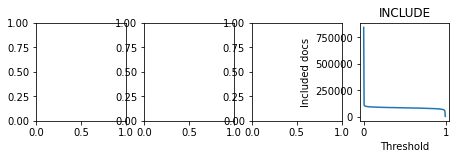

In [24]:
from sklearn.metrics import precision_recall_curve

df = pd.read_feather('../data/labels.feather')

def plot_precision_recall(y_prefix, MODEL, df):
    min_samples=15
    cols = [x for x in df.columns if re.match(y_prefix, x)]
    cols = [x for x in cols if df[x].sum()>min_samples]

    fig, axs = plt.subplots(len(cols),4, figsize=(7.4,len(cols)*1.8))
    
    t = np.arange(0,1,0.005)
    preds = np.load(f"../cluster-experiments/cv_results/{MODEL}__{y_prefix}__predictions.npy")
    included = np.zeros(t.shape)
    print(cols)
    for i, cname in enumerate(cols):
        if len(cols)>1:
            ax = axs[i,3]
        else:
            ax = axs[3]
            cname=f'.{cname}'
        ax.set_title(cname.split('.')[1])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Included docs')
        for j,t_value in enumerate(t):
            if len(cols)>1:
                included[j] = (preds[:,0]>=t_value).sum()
            else:
                included[j] = (preds>=t_value).sum()
        ax.plot(t, included)


    for k in range(3):
        pred = np.load(f"../cluster-experiments/cv_results/{MODEL}__{y_prefix}__{k}__outer_predictions.npy")
        ids = np.load(f"../cluster-experiments/cv_results/{MODEL}__{y_prefix}__{k}__outer_ids.npy", allow_pickle=True)
        pred_df = pd.DataFrame({"id":ids})
        for i, cname in enumerate(cols):
            pred_df[f'{cname}_pred']=pred[:,i]
            
        
        

        pred_df = pred_df.merge(df.loc[df['id'].isin(ids)].copy()[["id"]+cols])
        #unseen_df = unseen_df.merge(pred_df, how="left") 
        #print(unseen_df.shape)
        #return unseen_df
        for i, cname in enumerate(cols):
            ax = axs[i,0]
            y_true = pred_df[cname].replace(2,1)
            y_pred = pred_df[f'{cname}_pred']
            p, r, t = precision_recall_curve(y_true, y_pred)
            ax.plot(r,p)
            ax.set_xlim(0,1)
            ax.set_ylim(0,1)
            ax.set_aspect('equal')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            if k==0:
                ax.set_title(cname.split('.')[1])

            t = np.concatenate([np.array([0]),t])
            ax = axs[i,1]
            ax.plot(t,r)
            ax.set_xlim(0,1)
            ax.set_ylim(0,1)
            ax.set_aspect('equal')
            ax.set_xlabel('Threshold')
            ax.set_ylabel('Recall')  

            if k==0:
                ax.set_title(cname.split('.')[1])

            ax = axs[i,2]
            ax.plot(t,p)
            ax.set_xlim(0,1)
            ax.set_ylim(0,1)
            ax.set_aspect('equal')
            ax.set_xlabel('Threshold')
            ax.set_ylabel('Precision')

            if k==0:
                ax.set_title(cname.split('.')[1])

    fig.tight_layout()
    
plot_precision_recall('INCLUDE', 'climatebert', df)

['4 - 1. Economic instruments', '4 - 2. Regulatory Instruments', '4 - 3. Information, education and training', '4 - 4. Governance, strategies and targets', '4 - 5. Agreements']


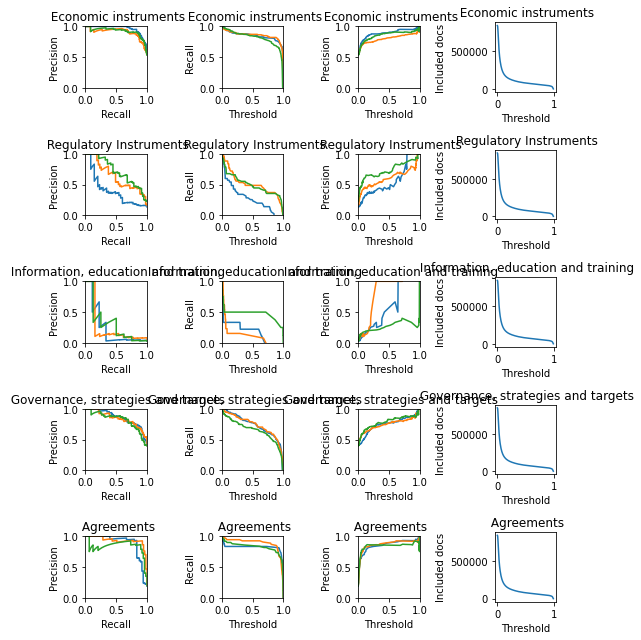

In [27]:
plot_precision_recall("4 -", "climatebert", df)

['8 - 01. AFOLU', '8 - 02. Buildings', '8 - 03. Industry', '8 - 04. Energy', '8 - 05. Transport', '8 - 06. Waste', '8 - 15. Cross-sectoral']


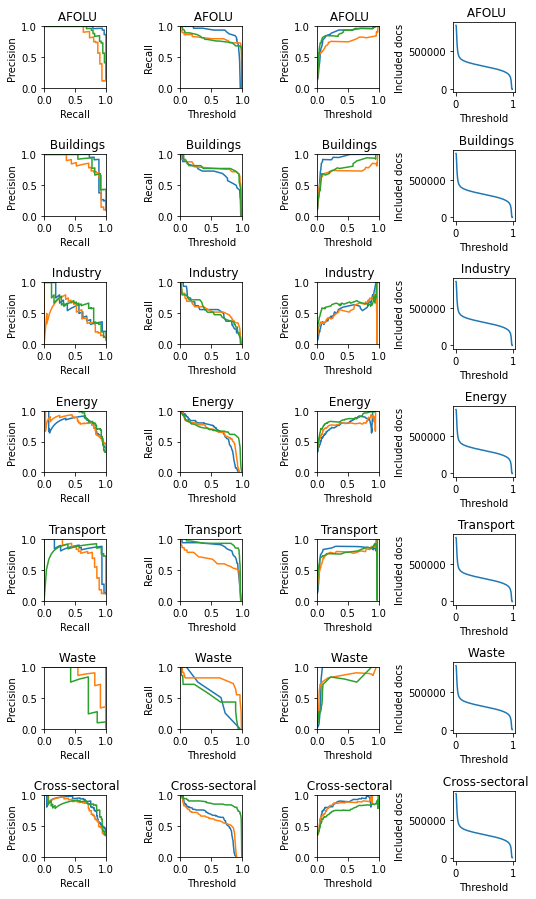

In [25]:
plot_precision_recall("8 -", "climatebert", df)

['19 - 0. Ex-post', '19 - 1. Ex-ante']


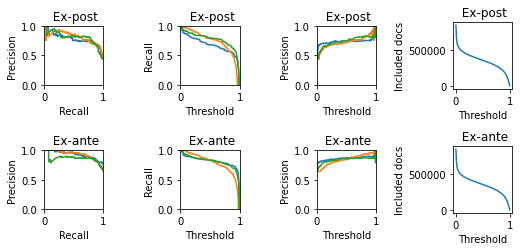

In [26]:
plot_precision_recall("19 -", "climatebert", df)

In [ ]:
r
